# CIFAR10

DOWNLOAD DATA FROM [HERE](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) AND PUT IT TO THE DATA FOLDER

The [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks. Such a situation is called **multiclass** classification in oppose to **multilabel** classification when each example may have multiple label.

One can see state-of-the-art results [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

In [1]:
import _pickle as cPickle
import tarfile

import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Fix random seed for reproducibility

In [3]:
np.random.seed(42)

# Data

Unarchive data

In [4]:
tar = tarfile.open("data/cifar-10-python.tar.gz", "r:gz")
tar.extractall("data")
tar.close()

## Reading

Data are stored as a memory dump with python $\text{dict}$ object. It was created using **pickle** function. To read one should "unpickle" it.

In [5]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='latin1')
    fo.close()
    return dict

Data are also splitted in to 5 pieces for conveniece. Let's read them all and concatenate

In [6]:
for b in range(1, 6):
    data_batch = unpickle("data/cifar-10-batches-py/data_batch_" + str(b))
    if b == 1:
        X_train = data_batch["data"]
        y_train = np.array(data_batch["labels"])
    else:
        X_train = np.append(X_train, data_batch["data"], axis=0)
        y_train = np.append(y_train, data_batch["labels"], axis=0)

Read test data. In this dataset train/test split is provided by authors of the dataset to be able to consistently evaluate solutions

In [7]:
data_batch = unpickle("data/cifar-10-batches-py/test_batch")
X_test = data_batch["data"]
y_test = np.array(data_batch["labels"])

Read meta-information file with the names of the classes

In [8]:
classes = unpickle("data/cifar-10-batches-py/batches.meta")["label_names"]

## Pre-processing

We have too many data

In [9]:
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 50000
Test size: 10000


Let's take only 10% of them to train faster

In [10]:
subsample_rate = 0.1

We want to preserve the same quantity ratio between classes. In python such an option is called **stratification**. Let's randomly (with fixed initial seed for the sake of reproducibility) divide part of train data

In [11]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The same for test

In [12]:
X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Indeed, we preserved the number of objects of each class

In [13]:
unique_train = np.unique(y_train, return_counts=True)
list(zip(np.array(classes)[unique_train[0]], unique_train[1]))

[('airplane', 500),
 ('automobile', 500),
 ('bird', 500),
 ('cat', 500),
 ('deer', 500),
 ('dog', 500),
 ('frog', 500),
 ('horse', 500),
 ('ship', 500),
 ('truck', 500)]

## Visualization

For now each object has the following shape

In [14]:
X_train[0].shape

(3072,)

$3072 = 32 \times 32 \times 3$ where $32 \times 32$ is the size of the image in pixels and $3$ is the number of channels (RGB)

To show this array as an image let's reshape it in the needed from with the shape $(32, 32, 1)$

In [15]:
def show_pic(x):
    plt.imshow(x.reshape((3, 32, 32)).transpose(1, 2, 0).astype("uint8"))
    plt.axis("off")

Draw one pic from each class

In [16]:
classes_idx_examples = np.zeros(10, dtype=np.int)
for i in range(10):
    classes_idx_examples[i] = np.where(y_train == i)[0][0]

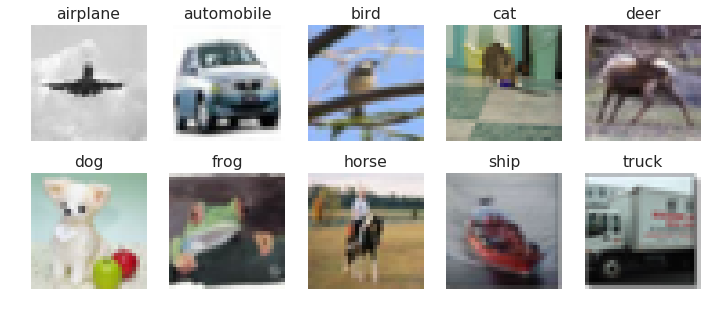

In [17]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(X_train[classes_idx_examples[i]])
    plt.title(classes[i])

# Bultin Models

Let's use Sklearn implementation of algorithms to have a benchmark.

Also one should **always** track the results of the experiments to be able to compare different approaches. Let's create pandas $\text{DataFrame}$ for this purpose.

In [18]:
results = pd.DataFrame(columns=["Model", "Test Accuracy"])

For now it is empty, but will be filled in later

In [19]:
results

,Model,Test Accuracy


## KNN

In this section the K Nearest Neighbors implementation from sklearn is presented (see theory below and in lectures)

For the beginning let's use default parametrs of KNN Sklearn classifier which are:
* $\text{n_neighbors} = 5$
* $L_2$ metric

In [20]:
# n_jobs is responsible for number of CPU cores used for computation
# -1 means use all available
model_knn_sklearn = KNeighborsClassifier(n_jobs=-1)

### Fitting

In [21]:
model_knn_sklearn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

### Evaluation

Predict answers on the test set

In [22]:
y_pred_test = model_knn_sklearn.predict(X_test)

Accuracy score with sklearn function

In [23]:
acc = accuracy_score(y_test, y_pred_test)

Append first row to the results table

In [24]:
results.loc[len(results)] = ["KNN Arbitary Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262


### Insight into predictions

Let's take one correct prediction from test set and look onto its nearest neighbors

In [25]:
correct_idx = np.where(y_pred_test == y_test)[0][0]

Get $k$ nearest neighbors via Sklearn interface (method $\text{kneighbors}$)

In [26]:
neighbors = model_knn_sklearn.kneighbors(X=[X_test[correct_idx]], return_distance=False)[0]

Let's see what examples are

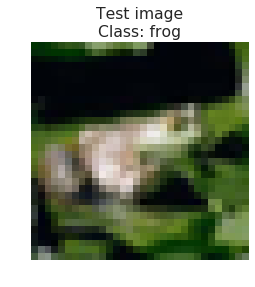

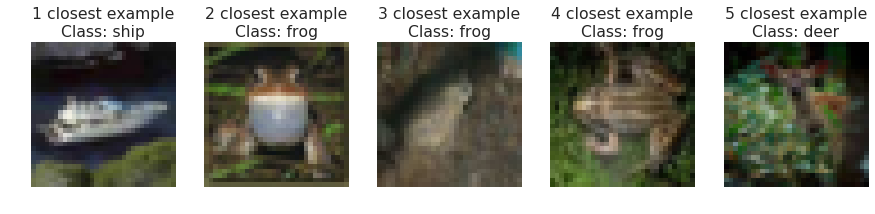

In [27]:
show_pic(X_test[correct_idx])
plt.title("Test image\nClass: " + classes[y_test[correct_idx]])
plt.show()
plt.figure(figsize=(15, 3))
for i, neighbor_idx in enumerate(neighbors):
    plt.subplot(1, 5, i + 1)
    show_pic(X_train[neighbor_idx])
    plt.title(str(i + 1) + " closest example\nClass: " + classes[y_train[neighbor_idx]])
plt.show()

Indeed, among five closest objects we have three frogs and ship pic which is very close to the initial frog pic.

It's **good** even the accuracy is bad, because our model can be explained in a very **intuitive** way

## Logistic Regression

The next thing to try is Multinomial Logistic Regression (see theory in lectures)

Here we used Sklearn $\text{SGDClassifier}$ with few options:
* $\text{loss} = \text{"log"} -$corresponds to Logistic Regression
* $\text{penalty} = \text{"none"}-$ for now we don't want to use regularization (using it should impove quality by few percents)
* $\text{max_iter} = 15 -$ the number of passes over the training data (aka epochs)
* $\text{average} = 10 -$ by default Stochastic Gradient Descent method is used. But it gitters massively (you should have observed it in LinearRegression homework). This is due to the not very good approximation of gradient (only by one example). To neglect this error we simply average gradient across last 10 steps.

In [28]:
model_lr_sklearn = SGDClassifier(loss="log", penalty="none", max_iter=15, average=10, n_jobs=-1)

### Fitting

In [29]:
model_lr_sklearn.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=10, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=15, n_iter=None,
       n_jobs=-1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

### Evaluation

Prediction

In [30]:
y_pred_test = model_lr_sklearn.predict(X_test)

Accuracy

In [31]:
acc = accuracy_score(y_test, y_pred_test)

Keeping table of results up-to-date

In [32]:
results.loc[len(results)] = ["LR Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343


$7\%$ better, not bad!

# Assignment

## K Nearest Neighbors: Grid Search
Take Sklearn implementation of KNN classifier and find out the best set of parameters from the following range:

$$
\text{n_neighbors} \in \{1 \ldots 5\}\\
\text{p} \in \{1 \ldots 3\}
$$

where $\text{n_neighbors}$ is the number of neighbors to consider and $\text{p}$ is the order of $L_p$ metric (see explanation below)

You're going to use **hold-out** sample approach for it.

The methodology should be the following:
* Iterate over the set of parameters (two nested loops in this case)
    * At each iteration one has fixed parameters $\text{n_neighbors} = n^*, \text{p} = p^*$. 
    * Build and train KNN classifier with these parameters on the train set.
    * Calculate the error (accuracy) on the test set and remember it.
* Choose the best set of parameters based on test set error

In [33]:
n_neighbors_range = np.arange(1, 6)
p_range = np.arange(1, 4)

In [34]:
test_error = np.zeros(shape=(len(n_neighbors_range), 
                             len(p_range)))

In [35]:
%%time
for n_neighbors in n_neighbors_range:
    for p in p_range:
        model_knn_sklearn = KNeighborsClassifier(n_neighbors=n_neighbors ,p=p, n_jobs=-1)

        model_knn_sklearn.fit(X_train, y_train)

        y_pred_test = model_knn_sklearn.predict(X_test)
        acc = accuracy_score(y_test, y_pred_test)
        
        test_error[n_neighbors - 1, p - 1] = acc

CPU times: user 1h 45min 34s, sys: 2.14 s, total: 1h 45min 36s
Wall time: 9min 18s


In [36]:
max_idx = np.unravel_index(np.argmax(test_error), test_error.shape)
acc = np.round(test_error[max_idx[0], max_idx[1]], 3)
print("Best model with accuracy of", acc)
print("n_neighbors =", n_neighbors_range[max_idx[0]])
print("p =", p_range[max_idx[1]])

Best model with accuracy of 0.293
n_neighbors = 3
p = 1


In [37]:
results.loc[len(results)] = ["KNN Grid Search Homegrown", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Homegrown,0.293


### Sklearn Example of CV
In this part you should not code anything. Just look how it should be done in pythonic way.

Let's use sklearn KNN for parameter selection

In [38]:
knn_sk = KNeighborsClassifier(n_jobs=-1)

And specify the dictionary of parameters we want to optimize along with their ranges

In [39]:
parameters = {'n_neighbors': n_neighbors_range, 'p': p_range}

Now let's unite all the data

In [40]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

$\text{PredefineSplit}$ function allows to use not random splitting and predefine it by yourself

In [41]:
split = PredefinedSplit(test_fold=[-1] * len(X_train) + [0] * len(X_test))

$\text{GridSearchCV}$ function do all the stuff. There are three main arguments:
* $\text{estimator} = \text{knn_sk} -$classifier to use; KNN from sklearn defined before
* $\text{param_grid} = \text{parameters} -$parameters ranges to test
* $\text{cv} = \text{split} -$splitting iterator to use

In [42]:
%%time
best_model = GridSearchCV(estimator=knn_sk, 
                          param_grid=parameters,  
                          cv=split, 
                          refit=False,  
                          return_train_score=False)
best_model.fit(X, y)

CPU times: user 1h 45min 29s, sys: 1.48 s, total: 1h 45min 31s
Wall time: 9min 25s


Let's retrieve best parameters

In [43]:
best_p = best_model.best_params_["p"]
best_n = best_model.best_params_["n_neighbors"]

In [44]:
print("Best model with accuracy of", best_model.best_score_)
print("n_neighbors =", best_n)
print("p =", best_p)

Best model with accuracy of 0.293
n_neighbors = 3
p = 1


And visualize the accuracy for each pair of parameters

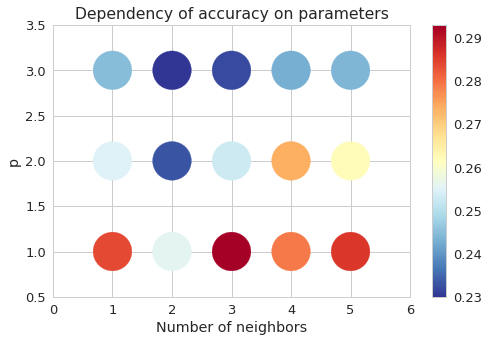

In [45]:
plt.figure(figsize=(8, 5))
sc = plt.scatter(best_model.cv_results_["param_n_neighbors"], 
                 best_model.cv_results_["param_p"], 
                 c=best_model.cv_results_["mean_test_score"], 
                 cmap = plt.get_cmap("RdYlBu_r"), 
                 s=1500)
plt.colorbar(sc)
plt.grid("on")
plt.gca().set_axisbelow(True)
plt.xlabel("Number of neighbors")
plt.ylabel("p")
plt.title("Dependency of accuracy on parameters")
plt.xlim([0, 6])
plt.ylim([0.5, 3.5])
plt.show()

Also let's choose the best $p^*$ and see how accuracy depends on number estimators for that $p$

In [46]:
p_idx = best_model.cv_results_["param_p"].data == best_p

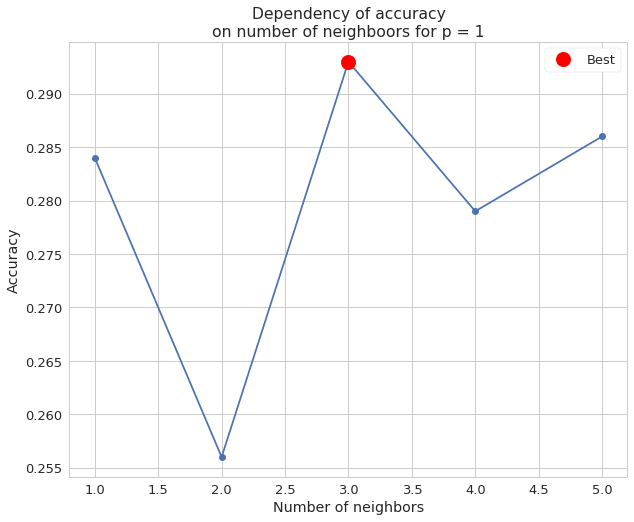

In [47]:
plt.figure(figsize=(10, 8))
plt.plot(best_model.cv_results_["param_n_neighbors"].data[p_idx], 
         best_model.cv_results_["mean_test_score"][p_idx], 
         "o-")
plt.plot([best_n], [best_model.cv_results_["mean_test_score"][p_idx][best_n - 1]], "or", markersize=15, label="Best")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title("")
plt.grid("on")
plt.legend(numpoints=1)
plt.title("Dependency of accuracy\non number of neighboors for p = " + str(best_p));

Let's add this result to the table of results. It should be the same as homegrown parameter selection

In [48]:
acc = best_model.best_score_

In [49]:
results.loc[len(results)] = ["KNN Grid Search Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Homegrown,0.293
3,KNN Grid Search Sklearn,0.293


## K Nearest Neighbors from scratch
* Implement K Nearest Neighbors classifier
* Take the best parameters from section 4.1 (or random if you do not accomplish 4.1)
* Train a classifier
* Report a quality

K Nearest Neighbors classier is the simplest **metric** classifier. The idea behind it is to find $k$ most *similar* objects and make a classification decision based on them.

To formalize the notion of similarity one should introduce the measure of the difference. Here we're going to use $L_p$ norm and induced metric.

$$
d_p(\mathbf{x}_1, \mathbf{x}_2) = \|\mathbf{x}_1 - \mathbf{x}_2\|_p = \left( \sum_{j=1}^{m}\left| x_{1, \,j} - x_{2, \,j} \right|^p \right)^{1/p}
$$

There are special names for some of the $L_p$ metrics:
* $p=1$ is Manhattan distance
* $p=2$ is Euclidian distance

For other metrics one can see [here](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)

Process of learning for KNN classifier is no more than just remembering all the training examples to find the closest one later on. There are smart ways (such as [KD trees](https://en.wikipedia.org/wiki/K-d_tree)) of storing training objects to be able to find nearest one very fast (faster than simply scanning through all of them). But here you need to implement it as a simple **array**.

For the prediction the following strategy is used:
* Find $k$ closest examples from train set
* Find the most frequent label among these $k$ closest objects (if there are few labels with the same number of objects than pick any label from those)
* Assign this label to new object

In [50]:
class KNNHomegrown(object):
    
    def __init__(self, n_neighbors=5, p=2):
        self.n_neighbors = n_neighbors
        self.p = p
        self._train_objects = np.array([])
        self._train_labels = np.array([])
        
    def _metric_func(self, x1, x2):
        """
        Return distance between two objects in Lp metric
        
        Args:
            x1(ndarray): first object
            x2(ndarray): second object
        Return:
            distance(float): returns Lp distance 
                             between x1 and x2
        """
        
        distance = np.linalg.norm(x1 - x2, ord=self.p, axis=1)
        
        return distance
    
    def _accuracy(self, y_true, y_pred):
        """
        Return the accuracy error measure
        
        Args:
            y_true(ndarray): true labels
            y_pred(ndarray): predicted labels
        Return:
            acc(float):      accuracy
        """
        
        acc = np.mean(y_true == y_pred)
        
        return acc
    
    def fit(self, X, y):
        """
        Fits the KNN classification model
        
        Args:
            X(ndarray): objects to train on
            y(ndarray): labels for each object
        Return:
            self
        """
        
        self._train_objects = X.astype(np.float)
        self._train_labels = y
        
        return self
        
    def _nearest_neighbors(self, X, return_distances=False):
        """
        Get n nearest neighbors for each object in X.
        For each object in X returns the array of n
        closest objects in train set.
        
        Args:
            X(ndarray): objects
        Return:
            nearest_indices(ndarray): array of nearest 
                                      objects indices
        """
        
        nearest_indices = np.zeros(shape=(X.shape[0], 
                                          self.n_neighbors), dtype=np.int) - 1
        nearest_distances = np.zeros(shape=(X.shape[0], 
                                            self.n_neighbors))
        
        for i in range(X.shape[0]):
            if (i + 1) % 100 == 0:
                print("Object {} out of {} has been predicted".format(i + 1, X.shape[0]))
            distances = self._metric_func(X[i], self._train_objects)
            index_order = np.argsort(distances)[:self.n_neighbors]
            nearest_indices[i] = index_order
            if return_distances:
                nearest_distances[i] = distances[index_order]

        if return_distances:
            return (nearest_indices, nearest_distances)
        else:
            return (nearest_indices,)
    
    def predict(self, X):
        """
        Predict the label for new objects
        
        Args:
            X(ndarray): objects to predict
        Return:
            y(ndarray): labels for objects
        """
        
        y = np.zeros(shape=(X.shape[0],)) - 1
        
        nearest_indices = self._nearest_neighbors(X)[0]
        nearest_labels = self._train_labels[nearest_indices]
        
        for i in range(X.shape[0]):
            y[i] = np.argmax(np.bincount(nearest_labels[i]))
        
        return y
    
    def score(self, X, y):
        """
        Return a dictionary which contains accuracy and Lp
        error metrics
        
        Args:
            X(ndarray):    objects to predict
            y(ndarray):    true labels for objects
        Return:
            metrics(dict): dictionary which contains metrics
        """
        
        y_pred = self.predict(X)
        
        acc = self._accuracy(y, y_pred)
        loss = self._metric_func(y, y_pred)
        
        metrics = {"acc": acc, "loss": loss}
        
        return metrics

In [51]:
model_knn_homegrown = KNNHomegrown(n_neighbors=3, p=1)

In [52]:
model_knn_homegrown.fit(X_train, y_train)

In [53]:
y_pred_test = model_knn_homegrown.predict(X_test)

Object 100 out of 1000 has been predicted
Object 200 out of 1000 has been predicted
Object 300 out of 1000 has been predicted
Object 400 out of 1000 has been predicted
Object 500 out of 1000 has been predicted
Object 600 out of 1000 has been predicted
Object 700 out of 1000 has been predicted
Object 800 out of 1000 has been predicted
Object 900 out of 1000 has been predicted
Object 1000 out of 1000 has been predicted


In [54]:
acc = accuracy_score(y_test, y_pred_test)

In [55]:
results.loc[len(results)] = ["KNN Best Homegrown", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Homegrown,0.293
3,KNN Grid Search Sklearn,0.293
4,KNN Best Homegrown,0.293


Check that your implementation gives the same result as Sklearn. There is no randomness in this algorithm so the answer should be almost the same.

## K Weighted Nearest Neighbors

In usual KNN every object from $k$ nearest neighbors is treated equally (it is called **majority voting**). But it is obvious that closer object should make bigger impact.

Majority voting can be thought the following: let's assign weight $1$ to each neighbor and then just see how many total weight do we have for each class.

Once we're fine with this understanding let us not to restrict ouselves with weights equal to $1$. Let's assume that weight of each object is **inversly proporional** to the distance to this object. It means that the smaller the distance is the more the weight will be $-$ exactly that we want. The classification is done with the same rule $-$ we just sum up weights for each class and choose the heaviest one. 

In this case we implicitly avoided one more problem $-$ now it is almost impossible to have equally heavy classes which means that the solution will always be unique.

In [56]:
class KNNWeightedHomegrown(KNNHomegrown):
    
    def __init__(self, n_neighbors=5, p=2, weight_mode="uniform"):
        super(KNNWeightedHomegrown, self).__init__(n_neighbors, p)
        
        if weight_mode != "distance":
            weight_mode = "uniform"
        self.weight_mode = weight_mode
        
        if self.weight_mode == "distance":
            self._weight_func = self._inverse_weights
        else:
            self._weight_func = self._uniform_weights
        
    def _inverse_weights(self, distances):
        """
        Generate neighbors weights which are 
        inversly proportional to the distances from
        object to its neighbor.

        Args:
            distances(ndarray): 2D numpy array
                first axes is objects
                second axes is neighbors of object
                in the cell (i; j) there is distance from
                the i^th object to its j^th nearest neighbor
        Return:
            weights(ndarray):   array of weights
        """ 
        
        weights = 1. / distances
        
        return weights
    
    def _uniform_weights(self, distances):
        """
        Generate neighbors weights which are 
        uniformly distributed.

        Args:
            distances(ndarray): 2D numpy array
                first axes is objects
                second axes is neighbors of object
                in the cell (i; j) there is distance from
                the i^th object to its j^th nearest neighbor
        Return:
            weights(ndarray):   array of weights
        """ 
        
        weights = np.ones(shape=distances.shape)
        
        return weights
    
    def predict(self, X):
        """
        Predict the label for new objects.
        Accounts for neighbors with weights in the
        mode defined in the constructor.
        
        Args:
            X(ndarray): objects to predict
        Return:
            y(ndarray): labels for objects
        """
        
        y = np.zeros(X.shape[0]) - 1
        
        nearest_indices, nearest_distances = self._nearest_neighbors(X, return_distances=True)
        nearest_labels = self._train_labels[nearest_indices]
        
        weights = self._weight_func(nearest_distances)
        
        for i in range(X.shape[0]):     
            counts = np.bincount(nearest_labels[i])
            weighted_sum = counts[nearest_labels[i]] * weights[i]
            y[i] = nearest_labels[i][np.argmax(weighted_sum)]
        
        return y

In [57]:
model_knn_weighted_homegrown = KNNWeightedHomegrown(n_neighbors=3, p=1)

In [58]:
model_knn_weighted_homegrown.fit(X_train, y_train)

In [59]:
y_pred_test = model_knn_weighted_homegrown.predict(X_test)

Object 100 out of 1000 has been predicted
Object 200 out of 1000 has been predicted
Object 300 out of 1000 has been predicted
Object 400 out of 1000 has been predicted
Object 500 out of 1000 has been predicted
Object 600 out of 1000 has been predicted
Object 700 out of 1000 has been predicted
Object 800 out of 1000 has been predicted
Object 900 out of 1000 has been predicted
Object 1000 out of 1000 has been predicted


In [60]:
acc = accuracy_score(y_test, y_pred_test)

In [61]:
results.loc[len(results)] = ["KNN Weighted Homegrown", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Homegrown,0.293
3,KNN Grid Search Sklearn,0.293
4,KNN Best Homegrown,0.293
5,KNN Weighted Homegrown,0.304


### Sklearn Weighted KNN
In this section you should not code anything again. Just see.

In [62]:
model_knn_weighted_sklearn = KNeighborsClassifier(n_jobs=-1, weights="distance", p=1, n_neighbors=3)

Fitting

In [63]:
model_knn_weighted_sklearn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=1,
           weights='distance')

Predict answers on the test set

In [64]:
y_pred_test = model_knn_weighted_sklearn.predict(X_test)

Accuracy score with sklearn function

In [65]:
acc = accuracy_score(y_test, y_pred_test)

Append first row to the results table

In [66]:
results.loc[len(results)] = ["KNN Weighted Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.343
2,KNN Grid Search Homegrown,0.293
3,KNN Grid Search Sklearn,0.293
4,KNN Best Homegrown,0.293
5,KNN Weighted Homegrown,0.304
6,KNN Weighted Sklearn,0.304


You can see that the result is the better (by $1\%$) than simple KNN with Grid Search. By doing Grid Search with weighted KNN we can do few percent more and reach Logistic Regression without regularization!

If you have time you're welcome to do it.

# Optional Assignment
Try to do a submission to the Kaggle competition on [CIFAR](https://www.kaggle.com/c/cifar-10). Note that the training set in the competition is exactly the same as in this homework while the test set contains some junk images:
```
To discourage certain forms of cheating (such as hand labeling) we have added 290,000 junk images in the test set. These images are ignored in the scoring. We have also made trivial modifications to the official 10,000 test images to prevent looking them up by file hash. These modifications should not appreciably affect the scoring. You should predict labels for all 300,000 images.
```
With 300k test images for KNN-based classification we recommend that you use an Azure CPU cloud instance and even in that case it can take a while.

Report your nick, rank and quality in this notebook when submitting an assignment solution.